In [1]:
from UTILITY_quickstart import *
import yaml

with open('setLattice_defaults.yml', 'r') as file:
    importedDefaultSettings = yaml.safe_load(file)

In [2]:
tao = initializeTao(
    inputBeamFilePathSuffix = '/beams/nmmToL0AFEND_2bunch_2024-02-16Clean/2024-02-16_2bunch_1e5Downsample_nudgeWeights.h5',
    #inputBeamFilePathSuffix = '/beams/L0AFEND_facet2-lattice.h5',

    csrTF = True,
    numMacroParticles=1e4,
    loadDefaultLatticeTF=False,


)

Environment set to:  /Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao
Tracking to end
CSR on
Base Tao lattice
Number of macro particles = 10000.0


In [3]:
trackBeam(tao, centerBC14 = False, centerBC20 = False, verbose = True)

Loaded activeBeamFile.h5
Set track_start = L0AFEND, track_end = end
Tracking!
trackBeam() exiting


In [4]:
savedData = {}

P = getBeamAtElement(tao, "PENT")
PDrive, PWitness = getDriverAndWitness(P)


for PActiveStr in ["PDrive", "PWitness"]:
    PActive = locals()[PActiveStr]
    for val in ["mean_x", "mean_y", "sigma_x", "sigma_y", "mean_xp", "mean_yp"]:
        savedData[f"{PActiveStr}_{val}"] = PActive[val]
        #print(f"""{PActiveStr}_{val} = {PActive[val]}""")

    #Note that this is not a standard deviation; also imposes cost for being off zero
    #savedData[f"{PActiveStr}_xCost"] = np.sqrt(np.mean((PActive.x)**2))
    #savedData[f"{PActiveStr}_yCost"] = np.sqrt(np.mean((PActive.y)**2))


    #Using the product was making it report flat beams...
    #savedData[f"{PActiveStr}_totalCost"] = savedData[f"{PActiveStr}_xCost"] * savedData[f"{PActiveStr}_yCost"]
    #Instead, average
    #savedData[f"{PActiveStr}_totalCost"] = 0.5*(savedData[f"{PActiveStr}_xCost"] + savedData[f"{PActiveStr}_yCost"])

    savedData[f"{PActiveStr}_sigmaSI90_x"] = 7.0 #smallestIntervalImpliedSigma(PActive.x, percentage = 0.90)
    savedData[f"{PActiveStr}_sigmaSI90_y"] = 6.8 #smallestIntervalImpliedSigma(PActive.y, percentage = 0.90)

    savedData[f"{PActiveStr}_emitSI90_x"] = smallestIntervalImpliedEmittance(PActive, plane = "x", percentage = 0.90)
    savedData[f"{PActiveStr}_emitSI90_y"] = smallestIntervalImpliedEmittance(PActive, plane = "y", percentage = 0.90)

    savedData[f"{PActiveStr}_zLen"] = smallestIntervalImpliedSigma(PActive.t * 3e8, percentage=0.9)

    savedData[f"{PActiveStr}_zCentroid"] = np.median(PActive.t * 3e8)

savedData["bunchSpacing"] = savedData["PWitness_zCentroid"] - savedData["PDrive_zCentroid"]

savedData["transverseCentroidOffset"] = np.sqrt(
        (savedData["PDrive_mean_x"] - savedData["PWitness_mean_x"])**2 + 
        (savedData["PDrive_mean_y"] - savedData["PWitness_mean_y"])**2
    )

savedData["lostChargeFraction"] = 1 - (tao.bunch_params("DTOTR")['n_particle_live'] / tao.bunch_params("BEGBC20")['n_particle_live'])

/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:302: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


In [5]:
savedData

{'PDrive_mean_x': -0.00017081517905504653,
 'PDrive_mean_y': -2.1688233468241185e-07,
 'PDrive_sigma_x': 0.000105003535742067,
 'PDrive_sigma_y': 1.485382318826958e-05,
 'PDrive_mean_xp': -5.225485178250497e-06,
 'PDrive_mean_yp': -8.086813345338391e-07,
 'PDrive_sigmaSI90_x': 7.0,
 'PDrive_sigmaSI90_y': 6.8,
 'PDrive_emitSI90_x': 0.00011025929602777207,
 'PDrive_emitSI90_y': 6.2229530466191325e-06,
 'PDrive_zLen': 1.8340414301745238e-05,
 'PDrive_zCentroid': 991.3317391737904,
 'PWitness_mean_x': -0.0006226171190324674,
 'PWitness_mean_y': -9.71612528672754e-07,
 'PWitness_sigma_x': 0.00016131059838451906,
 'PWitness_sigma_y': 6.890606288687302e-05,
 'PWitness_mean_xp': -2.1250523951814882e-05,
 'PWitness_mean_yp': -1.1417112451953718e-06,
 'PWitness_sigmaSI90_x': 7.0,
 'PWitness_sigmaSI90_y': 6.8,
 'PWitness_emitSI90_x': 2.817817586360428e-05,
 'PWitness_emitSI90_y': 9.196036988278835e-06,
 'PWitness_zLen': 2.1483895018015153e-05,
 'PWitness_zCentroid': 991.3318392585093,
 'bunchSpac

In [6]:
print(f"""Bunch spacing: \t\t{1e6 * savedData["bunchSpacing"] :.3g} um""")

print(f"""Transverse offset: \t{1e6*np.sqrt((savedData["PDrive_mean_x"] - savedData["PWitness_mean_x"])**2 + (savedData["PDrive_mean_y"] - savedData["PWitness_mean_y"])**2) :.3g} um""")

print("\nEmittances and sigmas - implied by 90% charge")
print(f"""Driver emittance: \t{1e6 * savedData["PDrive_emitSI90_x"] :.3g} × {1e6 * savedData["PDrive_emitSI90_y"] :.3g} um-rad""")
print(f"""Witness emittance: \t{1e6 * savedData["PWitness_emitSI90_x"] :.3g} × {1e6 * savedData["PWitness_emitSI90_y"] :.3g} um-rad""")

print(f"""Driver sigma_x,y,z: \t{1e6 * savedData["PDrive_sigmaSI90_x"] :.3g}, {1e6 * savedData["PDrive_sigmaSI90_y"] :.3g}, {1e6 * savedData["PDrive_zLen"] :.3g} um""")
print(f"""Witness sigma_x,y,z: \t{1e6 * savedData["PWitness_sigmaSI90_x"] :.3g}, {1e6 * savedData["PWitness_sigmaSI90_y"] :.3g}, {1e6 * savedData["PWitness_zLen"] :.3g} um""")

Bunch spacing: 		100 um
Transverse offset: 	452 um

Emittances and sigmas - implied by 90% charge
Driver emittance: 	110 × 6.22 um-rad
Witness emittance: 	28.2 × 9.2 um-rad
Driver sigma_x,y,z: 	7e+06, 6.8e+06, 18.3 um
Witness sigma_x,y,z: 	7e+06, 6.8e+06, 21.5 um


In [7]:
print("\nEmittances and sigmas - literal standard deviation")

print(f"""Driver emittance: \t{1e6 * PDrive["norm_emit_x"] :.3g} × {1e6 * PDrive["norm_emit_y"] :.3g} um-rad""")
print(f"""Witness emittance: \t{1e6 * PWitness["norm_emit_x"] :.3g} × {1e6 * PWitness["norm_emit_y"] :.3g} um-rad""")

print(f"""Driver sigma_x,y,z: \t{1e6 * PDrive["sigma_x"] :.3g}, {1e6 * PDrive["sigma_y"] :.3g}, {1e6 * PDrive["sigma_z"] :.3g} um""")
print(f"""Witness sigma_x,y,z: \t{1e6 * PWitness["sigma_x"] :.3g}, {1e6 * PWitness["sigma_y"] :.3g}, {1e6 * PWitness["sigma_z"] :.3g} um""")


Emittances and sigmas - literal standard deviation
Driver emittance: 	141 × 10.2 um-rad
Witness emittance: 	43.5 × 10.8 um-rad
Driver sigma_x,y,z: 	105, 14.9, 25.4 um
Witness sigma_x,y,z: 	161, 68.9, 20.6 um


Drive:


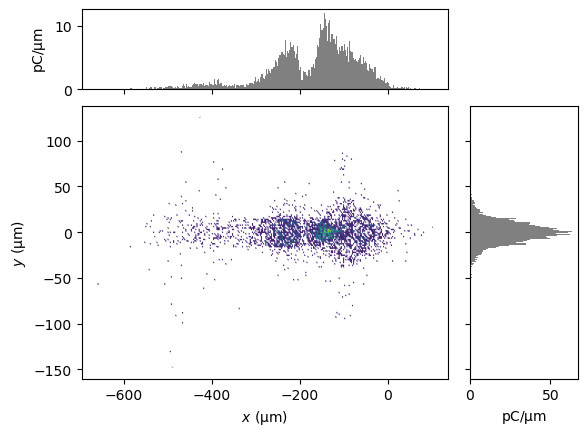

Witness:


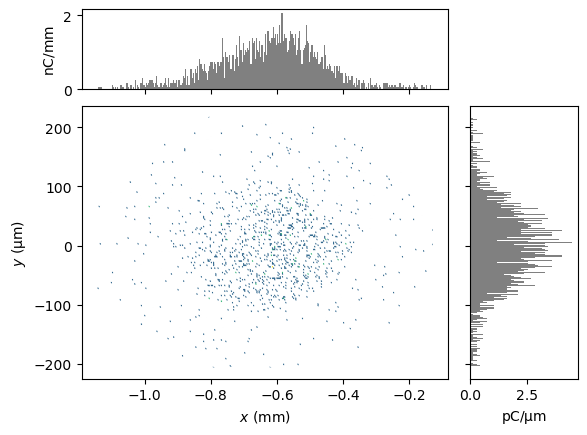

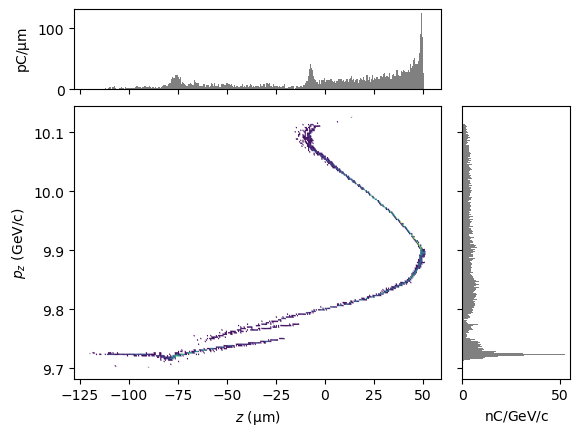

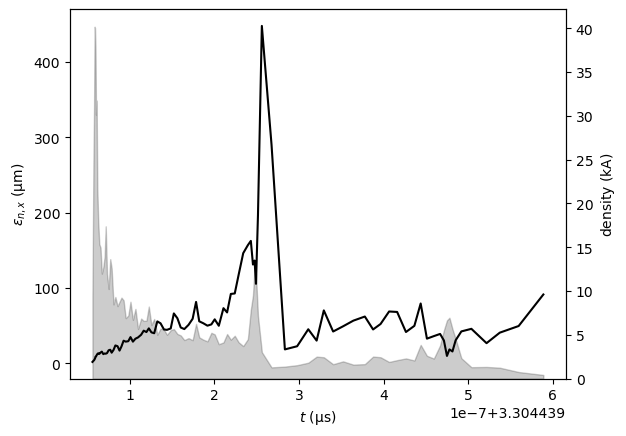

<Figure size 640x480 with 0 Axes>

In [8]:
print("Drive:")
display(plotMod(PDrive, 'x', 'y',  bins=300))
print("Witness:")
display(plotMod(PWitness, 'x', 'y',  bins=300))
display(plotMod(P, 'z', 'pz', bins=300))
#display(slicePlotMod(P, 'norm_emit_x', slice_key = "z", n_slice=100))
display(slicePlotMod(P, 'norm_emit_x', slice_key = "t", n_slice=100))
plt.clf()

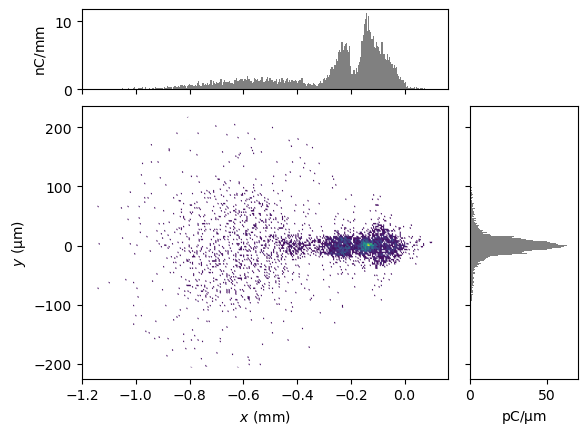

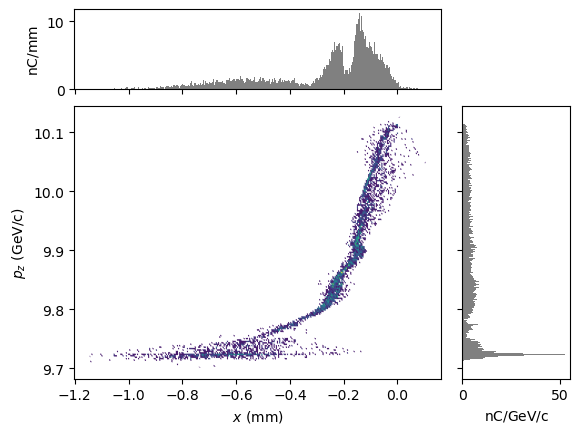

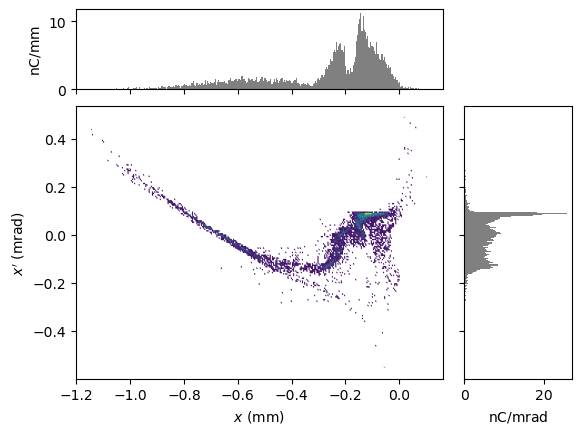

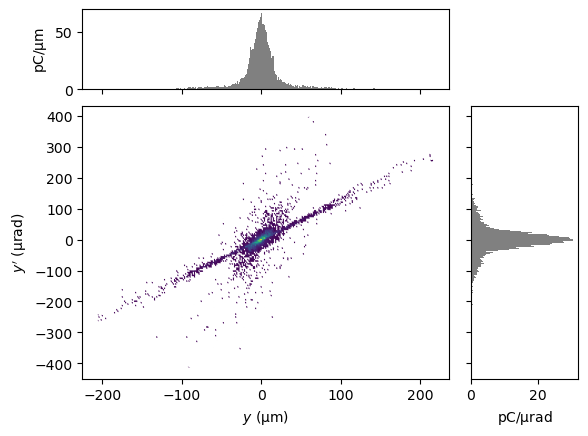

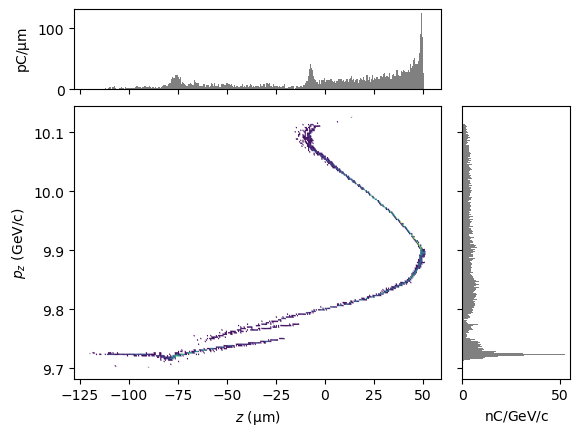

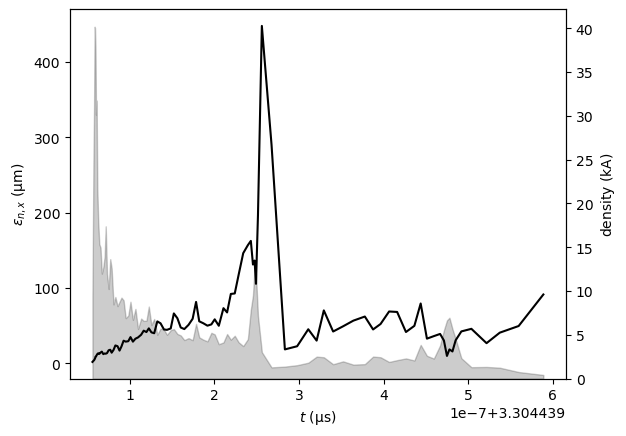

In [9]:
display(plotMod(P, 'x', 'y',  bins=300))
display(plotMod(P, 'x', 'pz', bins=300))
display(plotMod(P, 'x', 'xp', bins=300))
display(plotMod(P, 'y', 'yp', bins=300))
display(plotMod(P, 'z', 'pz', bins=300))
display(slicePlotMod(P, 'norm_emit_x',n_slice=100))

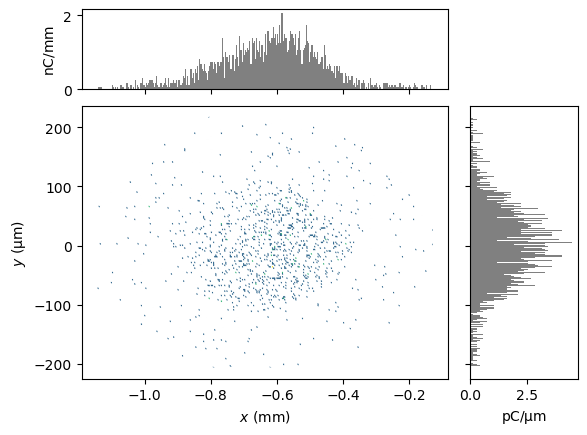

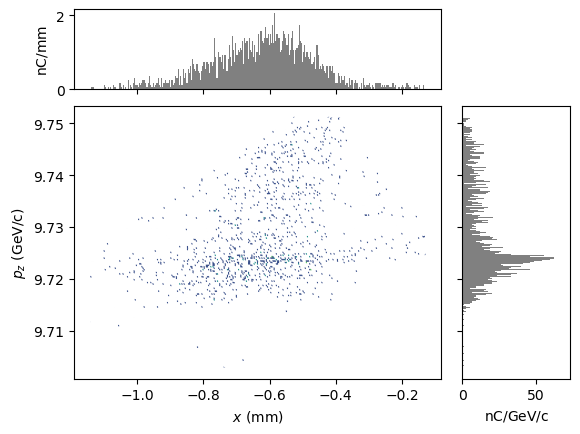

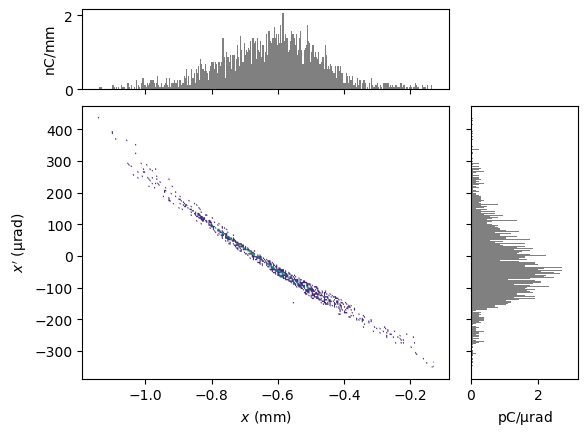

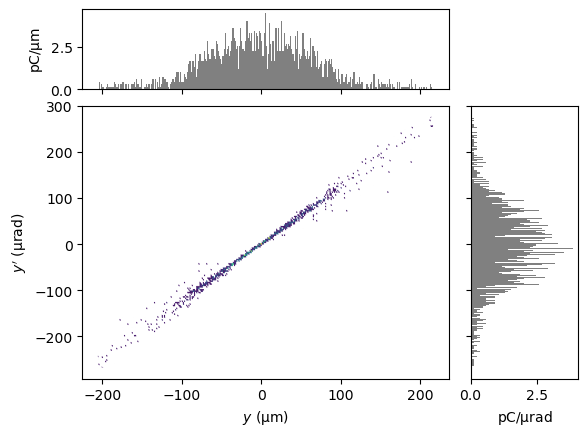

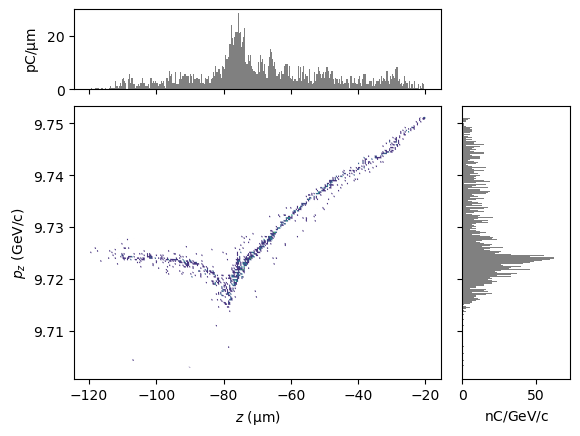

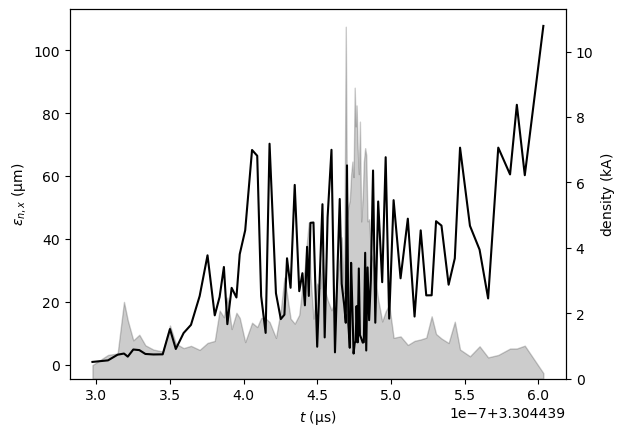

In [10]:
display(plotMod(PWitness, 'x', 'y',  bins=300))
display(plotMod(PWitness, 'x', 'pz', bins=300))
display(plotMod(PWitness, 'x', 'xp', bins=300))
display(plotMod(PWitness, 'y', 'yp', bins=300))
display(plotMod(PWitness, 'z', 'pz', bins=300))
display(slicePlotMod(PWitness, 'norm_emit_x',n_slice=100))


P, sigma x: 0.00022733083273985196
PDrive, sigma x: 0.000105003535742067
PWitness, sigma x: 0.00016131059838451906


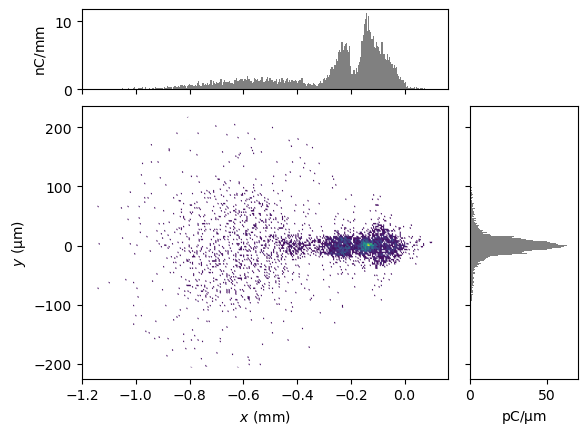

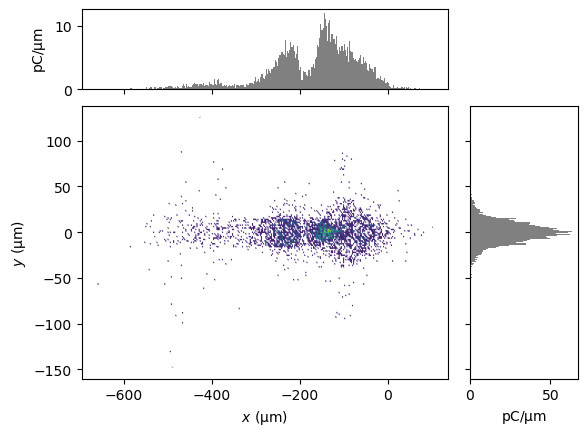

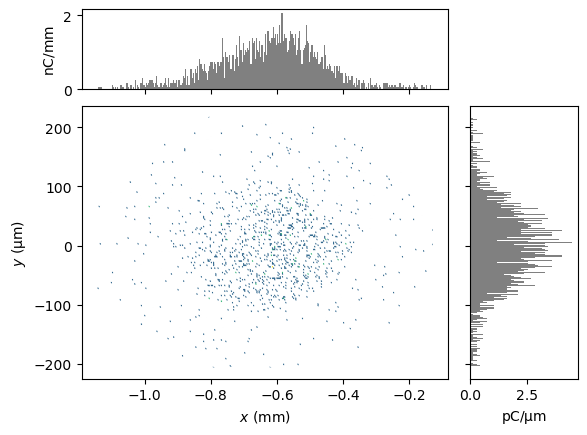

In [11]:
print(f"""P, sigma x: {P["sigma_x"]}""")
print(f"""PDrive, sigma x: {PDrive["sigma_x"]}""")
print(f"""PWitness, sigma x: {PWitness["sigma_x"]}""")

display(plotMod(P, 'x', 'y',  bins=300))
display(plotMod(PDrive, 'x', 'y',  bins=300))
display(plotMod(PWitness, 'x', 'y',  bins=300))

In [12]:
P.drift_to_z

<bound method ParticleGroup.drift_to_z of <ParticleGroup with 10000 particles at 0x175fb3f50>>

In [13]:
PTmp = ParticleGroup.drift_to_z(P)

In [14]:
?ParticleGroup.drift_to_z

Signature: ParticleGroup.drift_to_z(self, z=None)
Docstring: <no docstring>
File:      /opt/homebrew/anaconda3/envs/bmad/lib/python3.11/site-packages/pmd_beamphysics/particles.py
Type:      function

## BEGBC20

In [15]:
# savedData = {}

# P = getBeamAtElement(tao, "BEGBC20")
# PDrive, PWitness = getDriverAndWitness(P)


# for PActiveStr in ["PDrive", "PWitness"]:
#     PActive = locals()[PActiveStr]
#     for val in ["mean_x", "mean_y", "sigma_x", "sigma_y"]:
#         savedData[f"{PActiveStr}_{val}"] = PActive[val]
#         #print(f"""{PActiveStr}_{val} = {PActive[val]}""")

#     #Note that this is not a standard deviation; also imposes cost for being off zero
#     savedData[f"{PActiveStr}_xCost"] = np.sqrt(np.mean((PActive.x)**2))
#     savedData[f"{PActiveStr}_yCost"] = np.sqrt(np.mean((PActive.y)**2))


#     #Using the product was making it report flat beams...
#     #savedData[f"{PActiveStr}_totalCost"] = savedData[f"{PActiveStr}_xCost"] * savedData[f"{PActiveStr}_yCost"]
#     #Instead, average
#     savedData[f"{PActiveStr}_totalCost"] = 0.5*(savedData[f"{PActiveStr}_xCost"] + savedData[f"{PActiveStr}_yCost"])

#     savedData[f"{PActiveStr}_emitSI90_x"] = smallestIntervalImpliedEmittance(PActive, plane = "x", percentage = 0.90)
#     savedData[f"{PActiveStr}_emitSI90_y"] = smallestIntervalImpliedEmittance(PActive, plane = "y", percentage = 0.90)

#     savedData[f"{PActiveStr}_zLen"] = smallestIntervalImpliedSigma(PActive.t * 3e8, percentage=0.9)

#     savedData[f"{PActiveStr}_zCentroid"] = np.median(PActive.t * 3e8)

# savedData["bunchSpacing"] = savedData["PWitness_zCentroid"] - savedData["PDrive_zCentroid"]

# savedData